In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git
%cd /content/CSAW-HackML-2020/
DATA_PATH = '../drive/MyDrive/data'
GOOD_MODEL_PATH = '/content/drive/MyDrive/VAE_model/'

fatal: destination path 'CSAW-HackML-2020' already exists and is not an empty directory.
/content/CSAW-HackML-2020


# Data Definition

In [ ]:
import h5py
import numpy as np
from os.path import join
import keras
from architecture import Net
import tensorflow as tf
import collections
from collections import Counter


In [ ]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [ ]:
data_validation, labels_validation = data_loader(join(DATA_PATH, 'clean_validation_data.h5'))
data_test, labels_test = data_loader(join(DATA_PATH, 'clean_test_data.h5'))
data_poisoned, labels_poisoned = data_loader(join(DATA_PATH, 'sunglasses_poisoned_data.h5'))
data_anonymous, labels_anonymous = data_loader(join(DATA_PATH, 'anonymous_1_poisoned_data.h5'))

## Multi Trigger
data_poisoned_eyebrows, labels_poisoned_eyebrows = data_loader(join(DATA_PATH, 'Multi-trigger Multi-target/eyebrows_poisoned_data.h5'))
data_poisoned_lipstick, labels_poisoned_lipstick = data_loader(join(DATA_PATH, 'Multi-trigger Multi-target/lipstick_poisoned_data.h5'))
data_poisoned_sunglasses, labels_poisoned_sunglasses = data_loader(join(DATA_PATH, 'Multi-trigger Multi-target/sunglasses_poisoned_data.h5'))



print('Validation Shape:', data_validation.shape)
print('Validation Labels:', labels_validation.shape)
print('Test shape:', data_test.shape)


Validation Shape: (11547, 55, 47, 3)
Validation Labels: (11547,)
Test shape: (12830, 55, 47, 3)


### Normalization

In [ ]:
data_validation = data_validation/255
data_test = data_test/255
data_poisoned = data_poisoned/255
data_poisoned_eyebrows = data_poisoned_eyebrows/255
data_poisoned_lipstick = data_poisoned_lipstick/255
data_poisoned_sunglasses = data_poisoned_sunglasses/255
data_anonymous = data_anonymous/255

Sample Clean Image

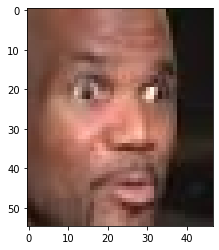

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_test[100]);

Sample Poisoned Image


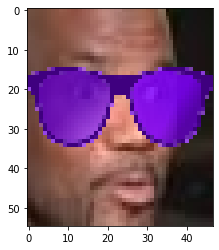

In [ ]:
temp = data_poisoned[100]
plt.imshow(temp);

#METHOD - 1 - VAE Model





In [ ]:
latent_space_dim = 1000
img_size = 55
shape = (56, 48, 3)
# Encoder
x = tf.keras.layers.Input(shape=shape, name="encoder_input")

encoder_conv_layer1 = tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tf.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tf.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tf.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tf.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tf.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tf.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tf.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tf.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tf.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tf.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tf.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tf.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tf.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tf.keras.models.Model(x, encoder_output, name="encoder_model")

##ENCODER DETAILS

In [ ]:
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 56, 48, 3)]  0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 56, 48, 3)    84          encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_norm_1 (BatchNormalizat (None, 56, 48, 3)    12          encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_leakyrelu_1 (LeakyReLU) (None, 56, 48, 3)    0           encoder_norm_1[0][0]             
______________________________________________________________________________________

In [ ]:
decoder_input = tf.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")

decoder_dense_layer1 = tf.keras.layers.Dense(units=np.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)

decoder_reshape = tf.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

decoder_conv_tran_layer1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tf.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tf.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tf.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tf.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

##DECODER DETAILS

In [ ]:
decoder = tf.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 1000)]            0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 10752)             10762752  
_________________________________________________________________
reshape (Reshape)            (None, 14, 12, 64)        0         
_________________________________________________________________
decoder_conv_tran_1 (Conv2DT (None, 14, 12, 64)        36928     
_________________________________________________________________
decoder_norm_1 (BatchNormali (None, 14, 12, 64)        256       
_________________________________________________________________
decoder_leakyrelu_1 (LeakyRe (None, 14, 12, 64)        0         
_________________________________________________________________
decoder_conv_tran_2 (Conv2DT (None, 28, 24, 64)      

## VAE MODEL DETAILS

In [ ]:
vae_input = tf.keras.layers.Input(shape=shape, name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tf.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 56, 48, 3)]       0         
_________________________________________________________________
encoder_model (Functional)   (None, 1000)              21600240  
_________________________________________________________________
decoder_model (Functional)   (None, 56, 48, 3)         10876035  
Total params: 32,476,275
Trainable params: 32,475,437
Non-trainable params: 838
_________________________________________________________________


In [ ]:
vae.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00005), loss=tf.keras.losses.mae)

In [ ]:
(x_train, y_train), (x_test, y_test) = (data_validation, labels_validation), (data_test, labels_test)


In [ ]:
def convert_to_size(desiredX, desiredY, data):
  padded_images = []
  for img in data:
      shape = img.shape
      xDiff = desiredX - shape[0]
      xLeft = xDiff//2
      xRight = xDiff-xLeft

      yDiff = desiredY - shape[1]
      yLeft = yDiff//2
      yRight = yDiff - yLeft

      padded_images.append(np.pad(img,((xLeft,xRight),(yLeft,yRight),(0,0)), mode='constant'))
  padded_images = np.array(padded_images)
  return padded_images

In [ ]:
x_train = convert_to_size(56, 48, x_train)
x_test = convert_to_size(56, 48, x_test)
x_poisoned = convert_to_size(56, 48, data_poisoned)
x_anonymous = convert_to_size(56, 48, data_anonymous)
x_sunglasses = convert_to_size(56, 48, data_poisoned_sunglasses)
x_eyebrows = convert_to_size(56, 48, data_poisoned_eyebrows)
x_lipstick = convert_to_size(56, 48, data_poisoned_lipstick)

In [ ]:
history = vae.fit(x_train, x_train, epochs=5, batch_size=32, shuffle=True)

Epoch 1/5
361/361 [==============================] - 8s 16ms/step - loss: 0.2546
Epoch 2/5
361/361 [==============================] - 6s 15ms/step - loss: 0.0814
Epoch 3/5
361/361 [==============================] - 6s 15ms/step - loss: 0.0672
Epoch 4/5
361/361 [==============================] - 6s 15ms/step - loss: 0.0604
Epoch 5/5
361/361 [==============================] - 6s 15ms/step - loss: 0.0575


In [ ]:
encoded_data = encoder.predict(x_test)
decoded_data = decoder.predict(encoded_data)

##LOSS vs EPOCH

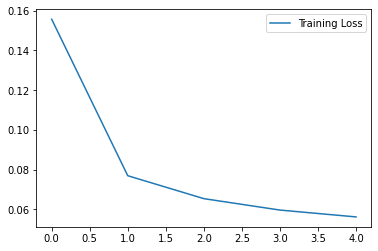

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

### Saving the model and encoder, decoder

In [ ]:
encoder.save(filepath="/content/drive/MyDrive/VAE_model/VAE_encoder.h5", overwrite=True, save_format='h5') 
decoder.save(filepath="/content/drive/MyDrive/VAE_model/VAE_decoder.h5", overwrite=True, save_format='h5') 
vae.save(filepath="/content/drive/MyDrive/VAE_model/VAE.h5", overwrite=True, save_format='h5')

Sample Eyebrow Poisoned Image

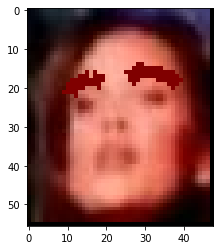

In [ ]:
poisoned_data_img = convert_to_size(56, 48, [x_eyebrows[100]])
plt.imshow(poisoned_data_img.reshape(56, 48, 3));

Reconstrcuted Eyebrow Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


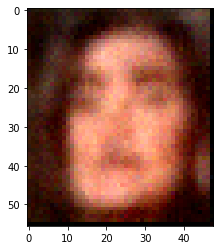

In [ ]:
poisoned_data_img = poisoned_data_img.reshape(1, 56, 48, 3)
poisoned_data = encoder.predict(poisoned_data_img)
poisoned_decoded_output = decoder.predict(poisoned_data)
plt.imshow(poisoned_decoded_output.reshape(56,48,3));

In [ ]:
final_threshold = 0
all_data = [x_train, x_test, x_poisoned, x_sunglasses, x_lipstick, x_anonymous, x_eyebrows]
names = ["x_train", "x_test", "x_poisoned", "x_sunglasses", "x_lipstick", "x_anonymous", "x_eyebrows"]
for data, name  in zip(all_data, names):
  reconstructions = vae.predict(data).astype('float32')
  data = data.astype('float32')
  train_loss = tf.keras.losses.mae(reconstructions, data)
  threshold = np.mean(train_loss) + np.std(train_loss)
  print("Reconstruction loss for",name,":", threshold,  "\n")
  if name == "x_train" or name == "x_test":
    final_threshold = max(final_threshold, threshold)

Reconstruction loss for x_train : 0.09597464 

Reconstruction loss for x_test : 0.09690079 

Reconstruction loss for x_poisoned : 0.20103425 

Reconstruction loss for x_sunglasses : 0.20100993 

Reconstruction loss for x_lipstick : 0.10481995 

Reconstruction loss for x_anonymous : 0.104821034 

Reconstruction loss for x_eyebrows : 0.11117971 



In [ ]:
final_threshold

0.09690079

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  labels = np.empty(threshold.shape)
  result = []
  for reconstruction, image in zip(reconstructions, data):
    loss = tf.keras.losses.mae(reconstruction, image)
    loss = np.mean(loss) + np.std(loss)
    # loss = np.mean(loss) + np.std(loss)
    valid = True if loss>threshold[0] else False
    result.append(valid)
  return np.array(result)

In [ ]:
all_data = [x_train, x_test, x_poisoned, x_sunglasses, x_lipstick, x_anonymous]
names = ["x_train", "x_test", "x_poisoned", "x_sunglasses", "x_lipstick", "x_anonymous"]
for data, name in zip(all_data, names):
  thresholds = np.array([final_threshold]*2000)
  preds = predict(vae, data[:2000], thresholds)
  count = Counter(preds)
  print("Predictions for ",name,":", count,  "\n")

Predictions for  x_train : Counter({False: 1247, True: 753}) 

Predictions for  x_test : Counter({False: 1198, True: 802}) 

Predictions for  x_poisoned : Counter({True: 2000}) 

Predictions for  x_sunglasses : Counter({True: 2000}) 

Predictions for  x_lipstick : Counter({True: 1061, False: 939}) 

Predictions for  x_anonymous : Counter({True: 1059, False: 941}) 



In [ ]:
all_data = [x_train, x_test, x_poisoned, x_sunglasses, x_lipstick, x_anonymous]
names = ["x_train", "x_test", "x_poisoned", "x_sunglasses", "x_lipstick", "x_anonymous"]
for data, name in zip(all_data, names):
  thresholds = np.array([final_threshold]*4000)
  preds = predict(vae, data[:4000], thresholds)
  count = Counter(preds)
  print("Predictions for ",name,":", count,  "\n")

Predictions for  x_train : Counter({False: 2480, True: 1520}) 

Predictions for  x_test : Counter({False: 2441, True: 1559}) 

Predictions for  x_poisoned : Counter({True: 4000}) 

Predictions for  x_sunglasses : Counter({True: 4000}) 

Predictions for  x_lipstick : Counter({True: 2145, False: 1855}) 

Predictions for  x_anonymous : Counter({True: 2140, False: 1860}) 

